In [6]:
import numpy as np
import math
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageChops
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

In [111]:
cellsize = 100

def readFont(ttx):
    """Given an XML TTX file, calculates the max number of points across all letters of interest, plus 1 per contour (outline)"""
    
    letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
    letters += [chr(i) for i in range(ord('a'), ord('z')+1)]
    letters += ['zero','one','two','three','four','five','six','seven','eight','nine']
    numletters = len(letters)

    points = np.zeros(numletters, int)
    contours = np.zeros(numletters, int)
    outputdim = 0
    
    #read overall ranges
    for i in range(0, numletters):
        glyph = ttx.find(r".//TTGlyph[@name='"+letters[i]+"']")
        #xMin[i] = int(glyph.get('xMin'))
        #xMax[i] = int(glyph.get('xMax'))
        #yMin[i] = int(glyph.get('yMin'))
        #yMax[i] = int(glyph.get('yMax'))
        for contour in glyph.iterfind('contour'):
            points[i] += len(list(contour.iterfind('pt')))
            contours[i]+=1
        outputdim = max(outputdim, points[i]+contours[i])

    print('points min/max/avg:', points.min(), points.max(), points.mean())
    print('contours min/max/avg:', contours.min(), contours.max(), contours.mean())

    return letters, outputdim

def angleDist(p1,p2, hidden):
    """Given two point tuples return the angle scaled to [-1,1], and distance scaled similarly"""
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    maxDim = 1500
    return math.atan2(dy,dx)/math.pi, math.sqrt(dx**2 + dy**2) * (-1 if hidden else 1) / maxDim  #negative distance means hidden

def setupInputOutput(ttx, letters, outputdim):
    """
    Read the actual points from all letters in the font into numpy array.
    Output is array of letters x points x 2 (angle in radians, distance).
    We use float according to https://github.com/fchollet/keras/issues/2218.
    """
    
    numletters = len(letters)
    Y = np.zeros((numletters, outputdim*2), np.float32)
    for i, l in enumerate(letters):
        glyph = ttx.find(r".//TTGlyph[@name='"+l+"']")
        p=0 #point count across all contours (shapes)
        startp = (0,0)

        #ttx contours are areas within the letter, like the outside and inside of an O
        for contour in glyph.iterfind('contour'):
            pts = contour.iterfind('pt')
            xy = [(int(pt.get('x')), int(pt.get('y'))) for pt in pts]
            #should i read the ttx 'on' attribute too? can't find documentation for it, might be related to bezier control points by observation

            #fill output matrix

            #start with hidden line to start position
            Y[i][p], Y[i][p+1] = angleDist(startp, xy[0], True)
            startp = xy[0]
            p+=2

            #then between points
            for n in range(len(xy)-1):
                Y[i][p], Y[i][p+1] = angleDist(xy[n],xy[n+1], False)
                p+=2
        
            #finally wrap last point to first in contour
            N=len(xy)-1
            Y[i][p], Y[i][p+1] = angleDist(xy[N],xy[0], False)
            p+=2


    #input is 'one-hot' array, one per letter
    X = np.identity(numletters, dtype=float)
    #print(Y[0])
    return X,Y


def drawAllLetters(Y):
    """Draw numpy array interpreted as a letter per row and each row containing (angle, dist) pairs."""
    columns = 13
    rows = math.ceil(Y.shape[0]/columns)
    def drawPoints(im, points):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.8
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(Y.shape[0]):
        y,x = divmod(i, columns)
        x *= cellsize
        y = (y+1)*cellsize-1
        points = []
        for j in range(0, Y.shape[1], 2):
            angle = Y[i][j]
            dist = Y[i][j+1]
            x2 = x+ abs(dist)*math.cos(angle*math.pi)*scale
            y2 = y- abs(dist)*math.sin(angle*math.pi)*scale
            if dist>0:
                points += (x2,y2)
            elif len(points)>2:
                im = drawPoints(im, points)
                points=[]
            x=x2
            y=y2
    if len(points)>2:
        im = drawPoints(im, points)
    return im



setup...
points min/max/avg: 22 100 53.3064516129
contours min/max/avg: 1 3 1.40322580645


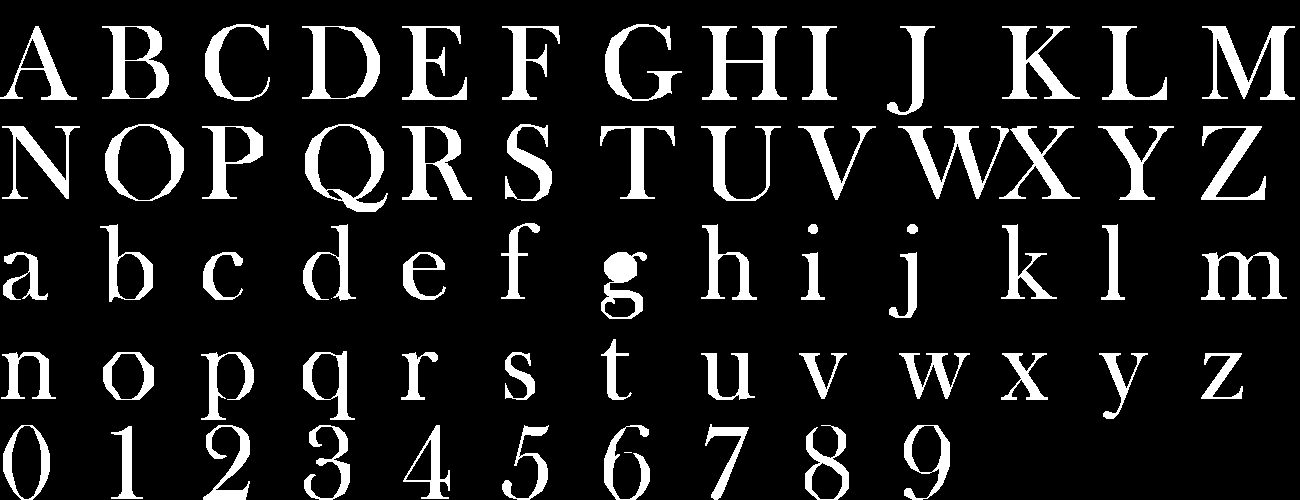

In [112]:
print('setup...')
ttx = ET.parse(r'deeper/BASKVILL.ttx') #read font data dumped from TrueType using fonttools
letters, outputdim = readFont(ttx)
X,Y = setupInputOutput(ttx, letters, outputdim)
drawAllLetters(Y)

In [113]:
print('compile model...')
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
#model.add(Dense(600, activation='relu'))
model.add(Dense(outputdim*2))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

print('fit the model...')
model.fit(X, Y, epochs=500, batch_size=len(letters))

compile model...
fit the model...
Epoch 1/500
62/62 [==============================] - 0s - loss: 0.1013 - acc: 0.0000e+00
Epoch 2/500
62/62 [==============================] - 0s - loss: 0.0978 - acc: 0.0000e+00
Epoch 3/500
62/62 [==============================] - 0s - loss: 0.0958 - acc: 0.0000e+00
Epoch 4/500
62/62 [==============================] - 0s - loss: 0.0943 - acc: 0.0000e+00
Epoch 5/500
62/62 [==============================] - 0s - loss: 0.0930 - acc: 0.0000e+00
Epoch 6/500
62/62 [==============================] - 0s - loss: 0.0919 - acc: 0.0000e+00
Epoch 7/500
62/62 [==============================] - 0s - loss: 0.0910 - acc: 0.0161
Epoch 8/500
62/62 [==============================] - 0s - loss: 0.0901 - acc: 0.0323
Epoch 9/500
62/62 [==============================] - 0s - loss: 0.0892 - acc: 0.0323
Epoch 10/500
62/62 [==============================] - 0s - loss: 0.0884 - acc: 0.0323
Epoch 11/500
62/62 [==============================] - 0s - loss: 0.0877 - acc: 0.0323
Epoch

evaluate the model...
32/62 [==============>...............] - ETA: 0s
acc: 19.35%
predict...
32/62 [==============>...............] - ETA: 0strue vs pred:
[ 0.         -0.96066666  1.          0.43799999  0.5         0.01533333
  0.02853544  0.05957255  0.17862386  0.02756003  0.17872898  0.04883077
  0.5         0.046       0.5         0.02733333  0.62270653  0.04964317
  0.62242347  0.0302067 ]
[-0.00257677 -0.95121872  0.98709857  0.42713103  0.50126839  0.01276128
  0.02715684  0.06061374  0.16671674  0.02971882  0.16110092  0.05795813
  0.4861089   0.05570764  0.48984793  0.03797165  0.61036122  0.04862231
  0.62131542  0.03071484]


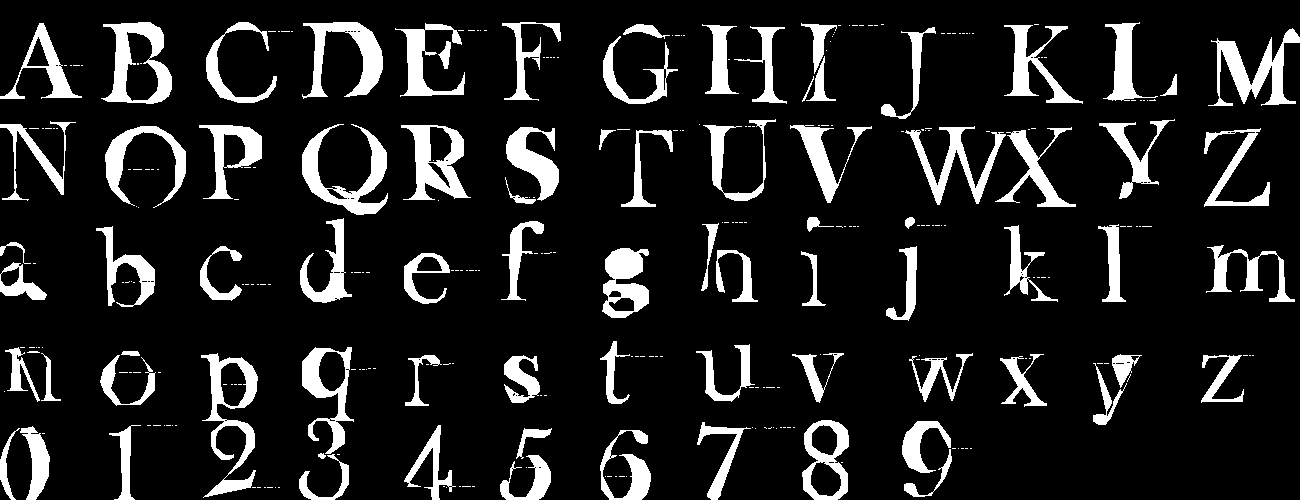

In [114]:
print('evaluate the model...')
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print('predict...')
newY = model.predict(X, verbose=1)

print("true vs pred:")
print(Y[0][:20])
print(newY[0][:20])
drawAllLetters(newY)

32/62 [==============>...............] - ETA: 0s

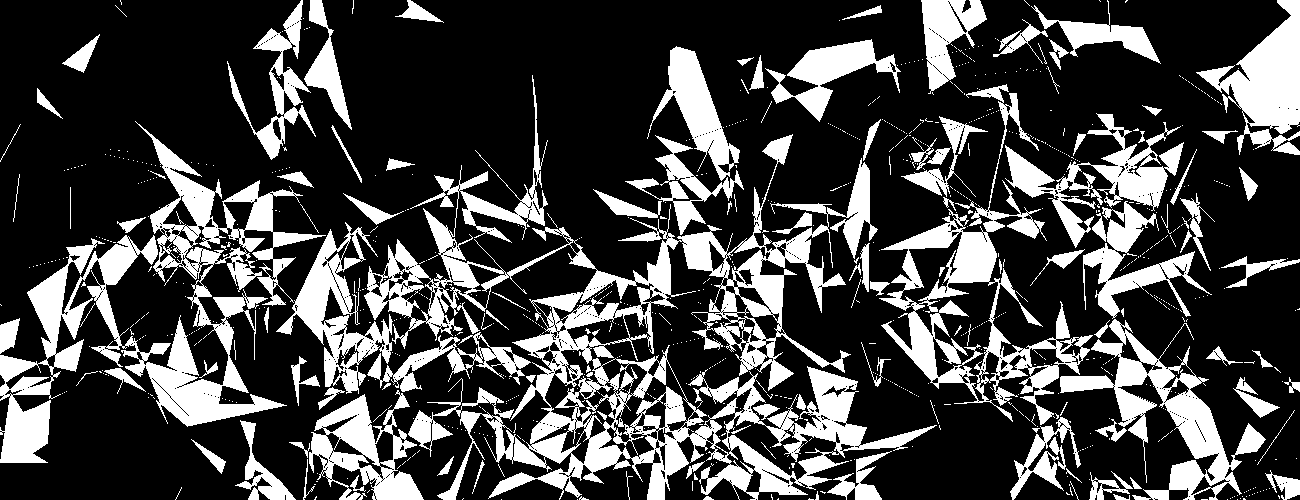

In [115]:
#now, what happens when we predict mixed letters?
newY = model.predict(np.random.random(X.shape), verbose=1)
drawAllLetters(newY)

13/13 [==============================] - 0s


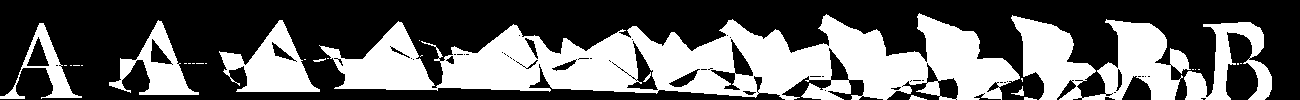

In [117]:
#what about interpolating between letters?  let's try gradually mixing A into B
#need array [[1, 0, ...], [1, 0.1, ...]]
A = X[0]
B = X[1]
steps=12
mix = np.array([A*(steps-i)/steps + i*B/steps for i in range(steps+1)])
#print(mix[:3])
newY = model.predict(mix, verbose=1)
drawAllLetters(newY)
#not very convincing :(, perhaps raw points rather than angle, dist pairs for the outline would be better
#also need to try interpolating A between two fonts